In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

In [3]:
data = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')
print(data.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


# Data Pre-processing

In [4]:
# Check for missing values
print(data.isnull().sum())

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [5]:
# Drop the 'CustomerID' column since it's irrelevent for clustering
data = data.drop(columns=['CustomerID'])

# Separate features into categorical and numerical columns
categorical_features = ['Gender']
numerical_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Create a column transformer with pipelines for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Apply the transformations
preprocessed_data = preprocessor.fit_transform(data)

# Convert the preprocessed data back to a DataFrame
preprocessed_data_df = pd.DataFrame(preprocessed_data, columns=['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Female'])
print(preprocessed_data_df.head())

        Age  Annual Income (k$)  Spending Score (1-100)  Gender_Female
0 -1.424569           -1.738999               -0.434801            1.0
1 -1.281035           -1.738999                1.195704            1.0
2 -1.352802           -1.700830               -1.715913            0.0
3 -1.137502           -1.700830                1.040418            0.0
4 -0.563369           -1.662660               -0.395980            0.0


Now we save the pre-processed dataset

In [6]:
preprocessed_data_df.to_csv('Preprocessed_Mall_Customers.csv', index=False)

# Exploratory Data Analysis (EDA)

## Performing EDA on the pre-processsed Dataset

### Loading the Pre-processed Data

In [7]:
data = pd.read_csv('/kaggle/working/Preprocessed_Mall_Customers.csv')
data.head()
data.describe()


,Age,Annual Income (k$),Spending Score (1-100),Gender_Female
count,2.000000e+02,2.000000e+02,2.000000e+02,200.000000
mean,-9.769963e-17,-2.131628e-16,-1.287859e-16,0.440000
std,1.002509e+00,1.002509e+00,1.002509e+00,0.497633
min,-1.496335e+00,-1.738999e+00,-1.910021e+00,0.000000
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01,0.000000
50%,-2.045351e-01,3.587926e-02,-7.764312e-03,0.000000
75%,7.284319e-01,6.656748e-01,8.851316e-01,1.000000
max,2.235532e+00,2.917671e+00,1.894492e+00,1.000000


### Distribution of numerical features

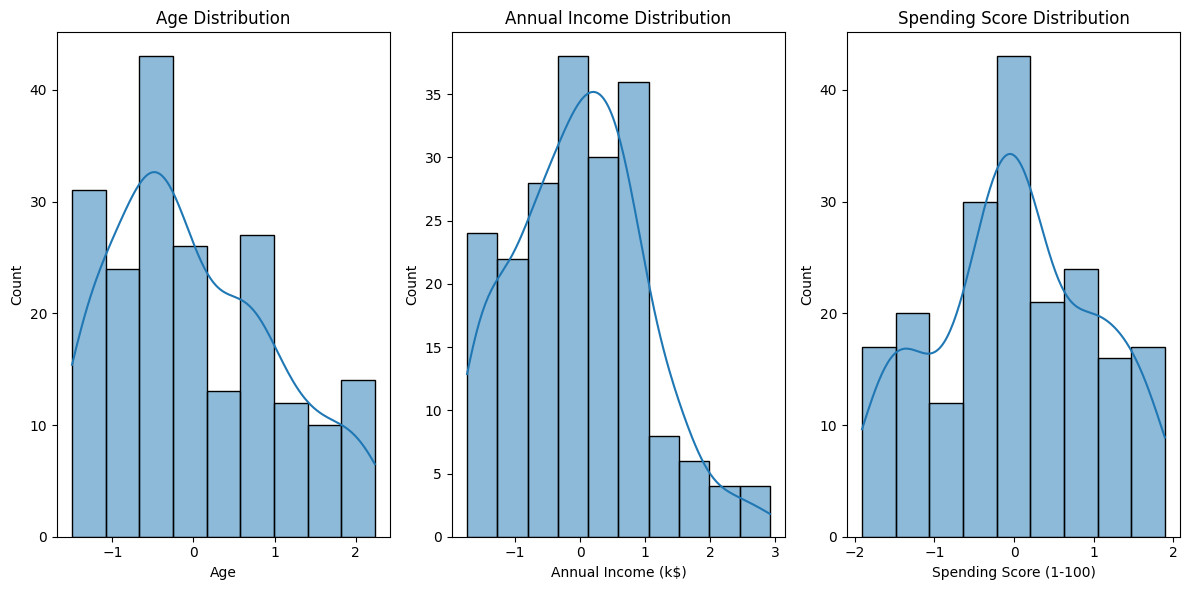

In [8]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.histplot(data['Age'], kde=True)
plt.title('Age Distribution')

plt.subplot(1, 3, 2)
sns.histplot(data['Annual Income (k$)'], kde=True)
plt.title('Annual Income Distribution')

plt.subplot(1, 3, 3)
sns.histplot(data['Spending Score (1-100)'], kde=True)
plt.title('Spending Score Distribution')

plt.tight_layout()
plt.show()

### Correlation Matrix

                             Age  Annual Income (k$)  Spending Score (1-100)  \
Age                     1.000000           -0.012398               -0.327227   
Annual Income (k$)     -0.012398            1.000000                0.009903   
Spending Score (1-100) -0.327227            0.009903                1.000000   
Gender_Female           0.060867            0.056410               -0.058109   

                        Gender_Female  
Age                          0.060867  
Annual Income (k$)           0.056410  
Spending Score (1-100)      -0.058109  
Gender_Female                1.000000  


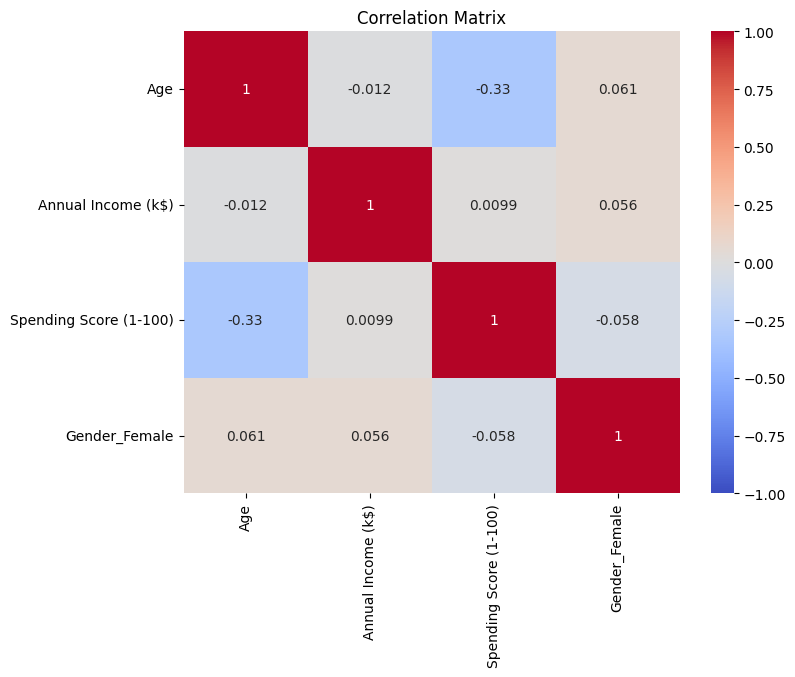

In [9]:
correlation_matrix = data.corr()
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

From the above correlation matrix, we can see a close relationship between Annual income and Spending score.

### Pairplot to visualize relationships between features

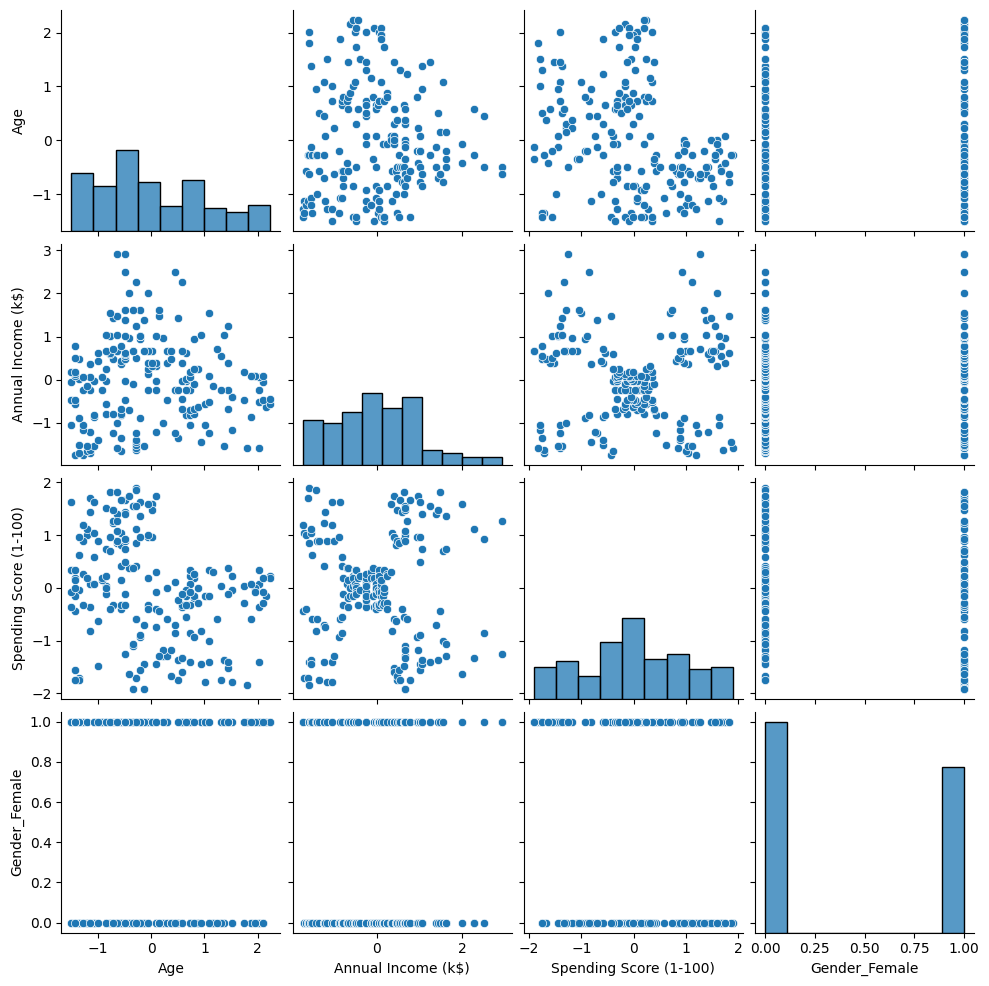

In [10]:
sns.pairplot(data)
plt.show()

### Outlier Check

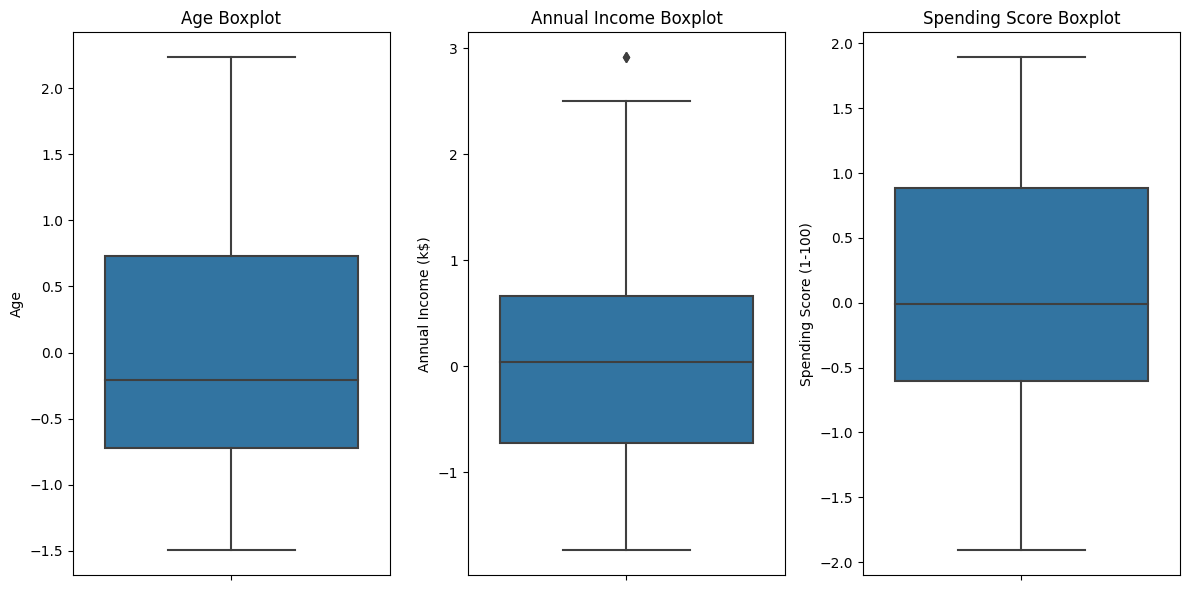

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.boxplot(y=data['Age'])
plt.title('Age Boxplot')

plt.subplot(1, 3, 2)
sns.boxplot(y=data['Annual Income (k$)'])
plt.title('Annual Income Boxplot')

plt.subplot(1, 3, 3)
sns.boxplot(y=data['Spending Score (1-100)'])
plt.title('Spending Score Boxplot')

plt.tight_layout()
plt.show()

### Visualizing the Average spending score and income by **Gender**

                    Age  Annual Income (k$)  Spending Score (1-100)
Gender_Female                                                      
0.0           -0.053953           -0.050002                0.051508
1.0            0.068668            0.063639               -0.065555


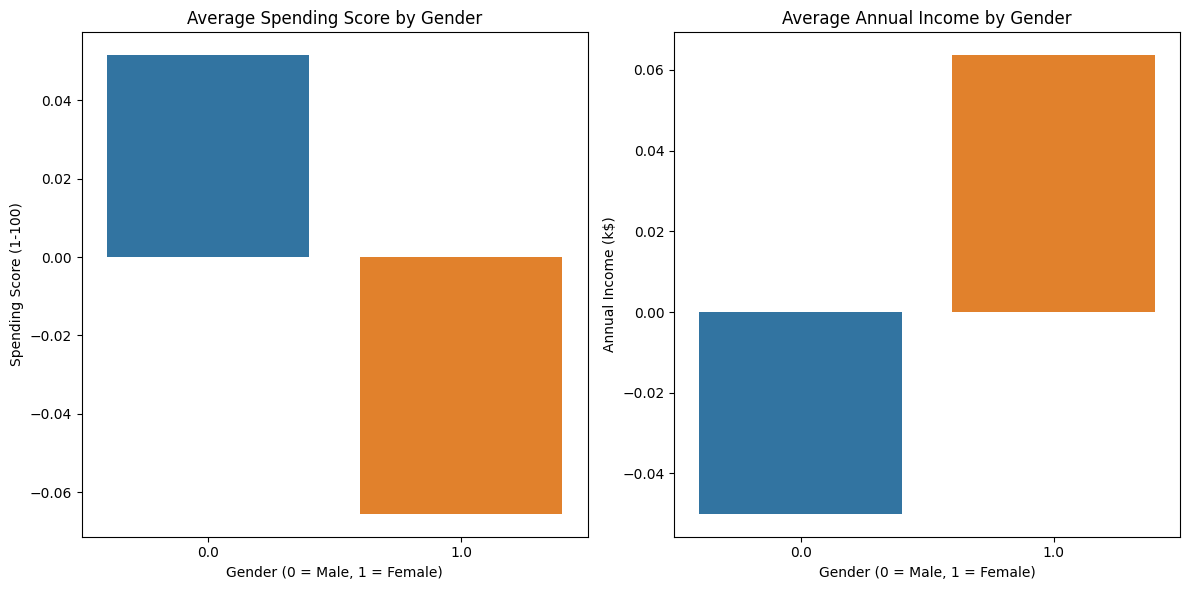

In [12]:
gender_groups = data.groupby('Gender_Female').mean()
print(gender_groups)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=gender_groups.index, y=gender_groups['Spending Score (1-100)'])
plt.title('Average Spending Score by Gender')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Spending Score (1-100)')

plt.subplot(1, 2, 2)
sns.barplot(x=gender_groups.index, y=gender_groups['Annual Income (k$)'])
plt.title('Average Annual Income by Gender')
plt.xlabel('Gender (0 = Male, 1 = Female)')
plt.ylabel('Annual Income (k$)')

plt.tight_layout()
plt.show()

# Clustering

* Here we are going to apply K-means clustering algorithm to perform customer segmentation
* We will first use Elbow method to determine the optimal number of clusters.
* Silhouette score will also be used to confirm the validity of clusters.
* After determining optimal number of cluters, we will create the model and then visualise the clusters.

### Elbow Method to determine optimal number of clusters

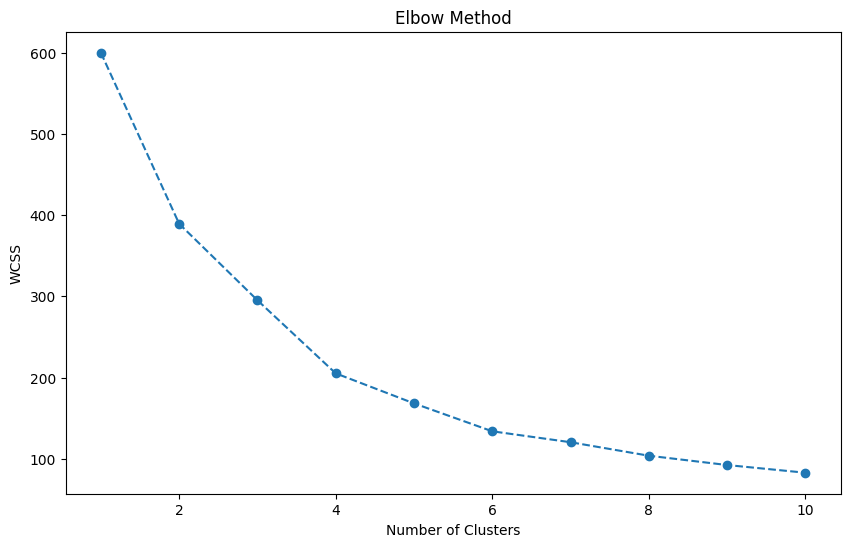

In [13]:
data = pd.read_csv('Preprocessed_Mall_Customers.csv')

# Drop the 'Gender_Female' column
data_for_clustering = data.drop(columns=['Gender_Female'])

wcss = []
max_clusters = 10
for i in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_for_clustering)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters+1), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

The point of decrease of WCSS is not certain between n= and n=6. Thus we apply Silhouette Method to determine the optimal number of clusters.

### Silhouette Score to determine optimal number of clusters

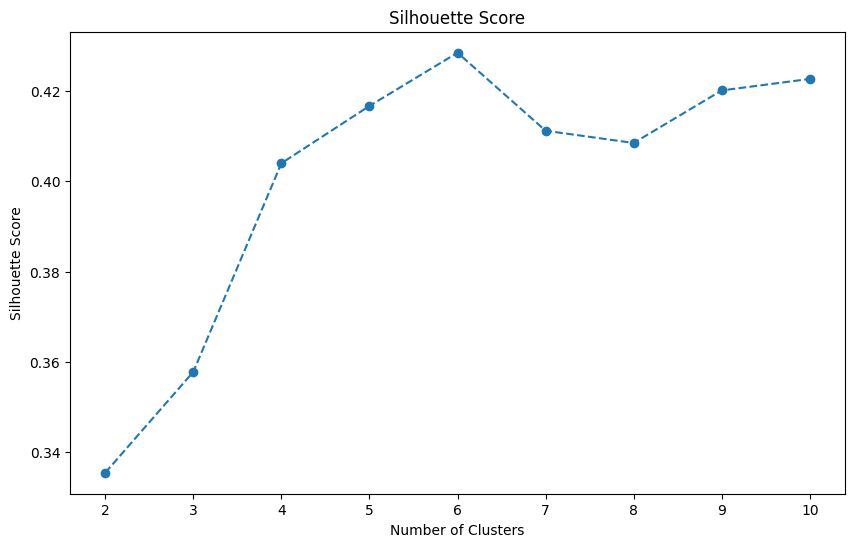

In [17]:
sil_scores = []
for i in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_for_clustering)
    labels = kmeans.labels_
    sil_scores.append(silhouette_score(data_for_clustering, labels))

plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters+1), sil_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

#### From the graph, it is clear that the Silhouette score is maximum for n = 6. Thus, we will consider k = 6 as our optimal number of clusters.

## Cluster and its Visualisation

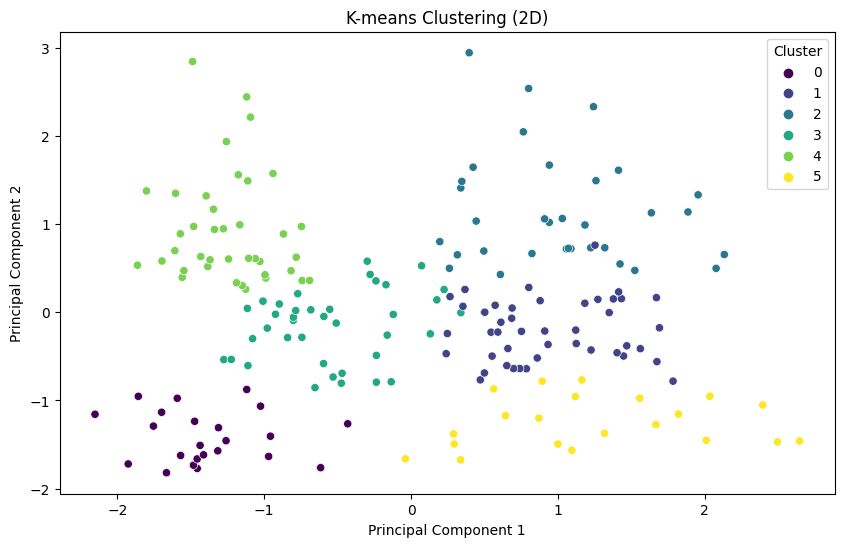

In [20]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(data_for_clustering)
cluster_labels = kmeans.labels_

# Visualize the clusters in 2D using PCA for dimensionality reduction
pca = PCA(n_components = 2, random_state = 42)
data_2d = pca.fit_transform(data_for_clustering)

# Create a DataFrame with the reduced data and cluster labels
clustered_data_2d = pd.DataFrame({'PC1': data_2d[:, 0], 'PC2': data_2d[:, 1], 'Cluster': cluster_labels})

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustered_data_2d, x='PC1', y='PC2', hue='Cluster', palette='viridis', legend='full')
plt.title('K-means Clustering (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

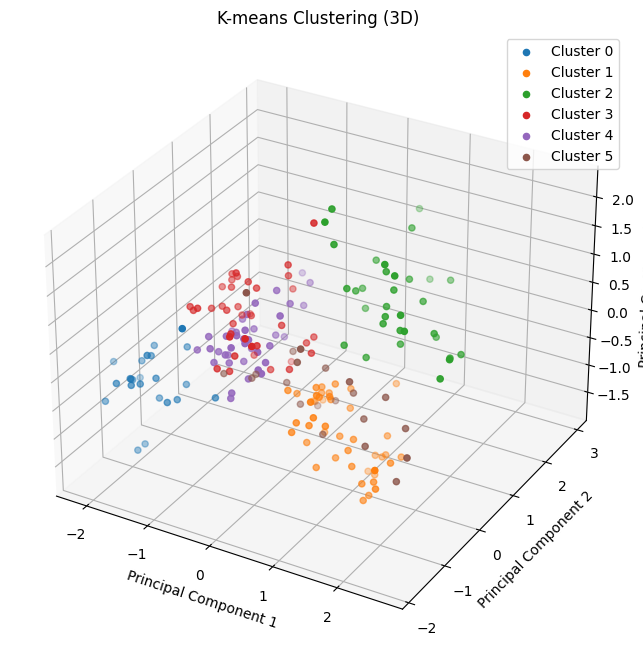

In [21]:
# Visualize the clusters in 3D using PCA for dimensionality reduction
pca = PCA(n_components=3, random_state=42)
data_3d = pca.fit_transform(data_for_clustering)

# Create a DataFrame with the reduced data and cluster labels
clustered_data_3d = pd.DataFrame({'PC1': data_3d[:, 0], 'PC2': data_3d[:, 1], 'PC3': data_3d[:, 2], 'Cluster': cluster_labels})

# Plot the clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(k):
    clustered_points = clustered_data_3d[clustered_data_3d['Cluster'] == cluster]
    ax.scatter(clustered_points['PC1'], clustered_points['PC2'], clustered_points['PC3'], label=f'Cluster {cluster}')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('K-means Clustering (3D)')
ax.legend()
plt.show()

### Analysis of each Cluster

               Age        Annual Income (k$)        Spending Score (1-100)  \
              mean median               mean median                   mean   
Cluster                                                                      
0        25.000000   23.0          25.260870   24.0              77.608696   
1        56.333333   54.0          54.266667   54.0              49.066667   
2        41.939394   43.0          88.939394   86.0              16.969697   
3        26.794872   26.0          57.102564   60.0              48.128205   
4        32.692308   32.0          86.538462   79.0              82.128205   
5        45.523810   46.0          26.285714   25.0              19.380952   

                       Gender  
        median count <lambda>  
Cluster                        
0         77.0    23   Female  
1         49.0    45   Female  
2         16.0    33     Male  
3         50.0    39   Female  
4         83.0    39   Female  
5         15.0    21   Female  


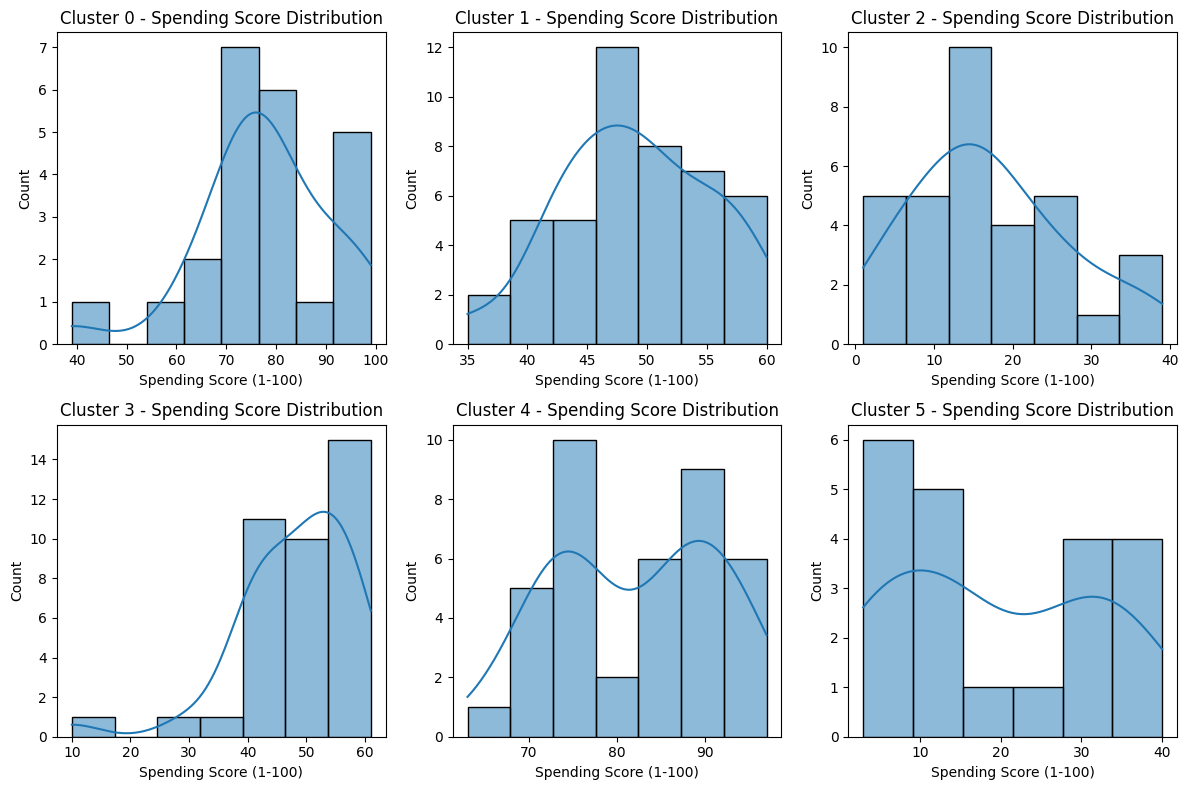

In [41]:
original_data = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

original_data['Cluster'] = cluster_labels
# Analyze each cluster
cluster_analysis = original_data.groupby('Cluster').agg({
    'Age': ['mean', 'median'],
    'Annual Income (k$)': ['mean', 'median'],
    'Spending Score (1-100)': ['mean', 'median', 'count'],
    'Gender': lambda x: x.mode()[0]
})

print(cluster_analysis)

# Visualize the characteristics of each cluster
plt.figure(figsize=(12, 8))
for i in range(k):
    plt.subplot(2, 3, i+1)
    sns.histplot(original_data[original_data['Cluster'] == i]['Spending Score (1-100)'], kde=True)
    plt.title(f'Cluster {i} - Spending Score Distribution')
plt.tight_layout()
plt.show()

## Main attributes of each segment:

####  Cluster 0:
* Mean age is around 25 and gender is predominantly female
* Low annual income, high spending
#### Cluster 1:
* Mean age is around 56 and gender is predominanntly female
* Moderate annual income, moderate spending
#### Cluster 2:
* Mean age is around 41 and gender is predominantly male
* High annual income, low spending
#### Cluster 3:
* Mean age is around 27 and gender is predominantly female
* High annual income, moderate spending
#### Cluster 4:
* Mean age is around 32 and gender is predominantly female
* High annual income, high spending
#### Cluster 5:
* Mean age is around 45 and gender is perdominantly female
* Low annual income, low spending